# Filtrowanie spamu oparte na modelu językowym

## Wstep

Filtry spamu zwykle tworzy się za pomocą metod uczenia maszynowego (ML), jednak coraz częściej stosuje się także techniki głębokiego uczenia (DL). W tym badaniu chciałem sprawdzić, jak te metody z zakresu DL radzą sobie w zadaniu wykrywania spamu w e-mailach. Celem jest określenie, która architektura jest najbardziej efektywna, a następnie najlepszy model zostanie zaimplementowany w mojej aplikacji. Szczególnie skupię się na tym, czy stosowanie bardziej złożonych bloków, takich jak LSTM, jest uzasadnione dla tego typu zadań. Główne modele oceniane w tym notebooku to modele wykorzystujące bloki LSTM, GRU oraz dwukierunkowe sieci rekurencyjne (bidirectional RNN).

## Przetwarzanie danych i importowanie niezbędnych bibliotek

In [ ]:
import pandas as pd
import numpy as np

import nltk 
from nltk.tokenize import word_tokenize 

import os
from collections import Counter
from tqdm.auto import tqdm
import string
from typing import List
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

import json

Dane do mojego treningu pochodziły z https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset

In [4]:
df = pd.read_csv("../data/combined_data.csv")

In [22]:
df[df['label'] == 0].head()

,label,text
2,0,computer connection from cnn com wednesday es...
4,0,thanks for all your answers guys i know i shou...
5,0,larry king live at escapenumber escapenumber p...
6,0,michael pobega wrote i'm not sure if it's the ...
7,0,hi i have this error tr sample escapenumber es...


In [11]:
df[df['label'] == 1]

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
3,1,university degree obtain a prosperous future m...
8,1,works gateway world art explore tattooing full...
9,1,upon this account he is not only very cautious...
...,...,...
83439,1,http printlost hk viagra escapenumber pills x ...
83441,1,lowest prices hbie qsxh gycj swlw swsszguohc z...
83444,1,now you can order software on cd or download i...
83445,1,dear valued member canadianpharmacy provides a...


Przykład wiadomości e-mail, która nie jest spamem

In [5]:
df.loc[2].text

" computer connection from cnn com wednesday escapenumber may escapenumber escapenumber escapenumber escapenumber pm edt in this report next generation toys read brain waves google expands personalization youtube wins webby old fashioned rabbit ears laptop review next generation toys read brain waves a startup company aims to add more realistic elements to video games by using brain wave reading technology to help game developers make gaming more realistic http www cnn com escapenumber tech fun games escapenumber escapenumber mind reading toys ap index html google expands personalization google is stepping up efforts to allow its users to personalize how they search the web http www cnn com escapenumber tech internet escapenumber escapenumber google personalization reut index html youtube wins webby the co founders youtube are among the winners of the annual webby online achievement awards http www cnn com escapenumber tech internet escapenumber escapenumber webby awards ap index html 

Przykład wiadomości e-mail będącej spamem

In [12]:
df.loc[0].text

'ounce feather bowl hummingbird opec moment alabaster valkyrie dyad bread flack desperate iambic hadron heft quell yoghurt bunkmate divert afterimage'

## Przygotowanie zbiorów danych

In [5]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\anpo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Tworzenie słownika odbywa się na podstawie słów, które pojawiają się więcej niż **threshold = 25** razy. W słowniku uwzględniamy również:   
**\<unk>** - dla nieznanego słowa   
**\<bos>** - oznaczające początek zdania    
**\<eos>** - oznaczające koniec zdania  
**\<pad>** - token do dopełniania, używany do wyrównania długości zdań w batchu

In [6]:
words = Counter()
for text in tqdm(df.text.array):
    processed_text = text.lower().translate(
    str.maketrans("", "", string.punctuation))
    
    for token in word_tokenize(processed_text):
        words[token] += 1 
        
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])

count_treshold = 25

for token, cnt in words.items():
    if cnt >= count_treshold:
        vocab.add(token)
        
print(f"Length of the vocabular is {len(vocab)}")

100%|██████████| 83448/83448 [00:40<00:00, 2067.29it/s]

Length of the vocabular is 28872


Tworzenie słowników słów wraz z odpowiadającymi im indeksami oraz zapisywanie ich, aby aplikacja mogła poprawnie działać.

In [ ]:
word2ind = {word : index for index, word in enumerate(vocab)}

In [ ]:
os.makedirs('../json_data', exist_ok=True)

with open('../json_data/word2ind.json', 'w') as f:
    json.dump(word2ind, f)

Utworzenie klasy zbioru danych, która zamienia każde słowo na odpowiadający mu indeks oraz tworzy batch’e do trenowania z tekstami i etykietami.

In [9]:
class WordDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels
        assert len(sentences) == len(labels)
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']
        
    def __getitem__(self, idx: int):
        processed_text = self.sentences[idx].lower().translate(
            str.maketrans("", "", string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id)
                               for word in word_tokenize(processed_text)]
        tokenized_sentence += [self.eos_id]
        
        return {
            'text': tokenized_sentence,
            'label': self.labels[idx] 
        }

    def __len__(self):
        return len(self.labels)

def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256):
    lens = [len(sentence['text']) for sentence in input_batch]
    max_len = min(max(lens), max_len)
    
    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_len]
        sequence['text'] += [pad_id] * (max_len - len(sequence['text']))
        new_batch.append(sequence['text'])
        
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([batch['label'] for batch in input_batch]).to(device)
    
    return {
        'text' : sequences,
        'label' : labels
    }

Podział danych na zbiory treningowy, testowy i walidacyjny oraz utworzenie loaderów danych.

In [ ]:
train_data, val_data = train_test_split(df, test_size=10000, stratify=df['label'], random_state=42)

batch_size = 32

train_dataset = WordDataset(train_data.text.array, train_data.label.array)
val_dataset = WordDataset(val_data.text.array, val_data.label.array)

train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

val_dataloader = DataLoader(
    val_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Funkcje trenowania i ewaluacji

In [ ]:
def train(model, criterion, optimizer, train_loader, val_loader, num_epoch):
    losses_train = []
    losses_val = []
    accuracy = []
    
    for epoch in range(num_epoch):
        epoch_losses_train = []
        epoch_losses_val = []
        
        # Training Phase
        model.train()
        for i, batch in enumerate(tqdm(train_loader, desc=f'Train epoch {epoch + 1}')):
            optimizer.zero_grad()
            logits = model(batch['text'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses_train.append(loss.item())
        
        # Evaluation Phase
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                logits = model(batch['text'])
                loss = criterion(logits, batch['label'])
                epoch_losses_val.append(loss.item())
        
        avg_loss_train = sum(epoch_losses_train) / len(epoch_losses_train)
        avg_loss_val = sum(epoch_losses_val) / len(epoch_losses_val)
        acc_val = evaluate(model, val_loader)
        
        losses_train.append(avg_loss_train)
        losses_val.append(avg_loss_val)
        accuracy.append(acc_val)
        
        print(f'Epoch {epoch + 1}/{num_epoch} - '
              f'Train Loss: {avg_loss_train:.4f}, '
              f'Val Loss: {avg_loss_val:.4f}, '
              f'Accuracy: {acc_val:.4f}')
    
    return losses_train, losses_val, accuracy

In [ ]:
def evaluate(model, val_loader):
    predictions = []
    target = []
    with torch.no_grad():
        for batch in val_loader:
            logits = model(batch['text'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
   
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    
    return (predictions == target).float().mean().item()     

In [ ]:
def show_loss_and_accuracy_history(losses_train, losses_val, accuracy):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6)) 

    # Plot losses
    ax1.plot(losses_train, label='Train', color='red')
    ax1.plot(losses_val, label='Val', color='blue')
    ax1.set_title('Loss History')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epochs')
    ax1.grid(True)
    ax1.legend()

    
    ax2.plot(accuracy, label='Accuracy', color='green')
    ax2.set_title('Accuracy History')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.grid(True)
    ax2.legend() 
    
    plt.tight_layout() 
    plt.show()

## Model językowy z blokiem LSTM

In [20]:
class LM(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind['<pad>'])
        self.LSTM = nn.LSTM(hidden_dim, int(hidden_dim / 2), num_layers = 3, batch_first = True, dropout = 0.1)
          
        self.linear = nn.Sequential(
            nn.Linear(int(hidden_dim / 2), hidden_dim),
            nn.Tanh(),
            nn.Dropout(p=0.3)
        )
        self.prediction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        
        output, (hidden, cell) = self.LSTM(embeddings)
        output = output.mean(dim = 1)
        
        return self.prediction(self.linear(output))

Zmienne potrzebne do deklaracji treningu

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_train, losses_val, accuracy = train(model, criterion, optimizer, train_dataloader, val_dataloader, 10)

Train epoch 1: 100%|██████████| 2312/2312 [15:24<00:00,  2.50it/s]


Epoch 1/10 - Train Loss: 0.0870, Eval Loss: 0.0405, Accuracy: 0.9883


Train epoch 2: 100%|██████████| 2312/2312 [17:27<00:00,  2.21it/s]  


Epoch 2/10 - Train Loss: 0.0278, Eval Loss: 0.0327, Accuracy: 0.9911


Train epoch 3: 100%|██████████| 2312/2312 [16:42<00:00,  2.31it/s]


Epoch 3/10 - Train Loss: 0.0158, Eval Loss: 0.0399, Accuracy: 0.9887


Train epoch 4: 100%|██████████| 2312/2312 [16:02<00:00,  2.40it/s]


Epoch 4/10 - Train Loss: 0.0092, Eval Loss: 0.0452, Accuracy: 0.9891


Train epoch 5: 100%|██████████| 2312/2312 [16:00<00:00,  2.41it/s]


Epoch 5/10 - Train Loss: 0.0069, Eval Loss: 0.0706, Accuracy: 0.9847


Train epoch 6: 100%|██████████| 2312/2312 [32:50<00:00,  1.17it/s]    


Epoch 6/10 - Train Loss: 0.0052, Eval Loss: 0.0589, Accuracy: 0.9898


Train epoch 7: 100%|██████████| 2312/2312 [18:52<00:00,  2.04it/s]  


Epoch 7/10 - Train Loss: 0.0040, Eval Loss: 0.0784, Accuracy: 0.9868


Train epoch 8: 100%|██████████| 2312/2312 [16:17<00:00,  2.36it/s]


Epoch 8/10 - Train Loss: 0.0036, Eval Loss: 0.0436, Accuracy: 0.9904


Train epoch 9: 100%|██████████| 2312/2312 [31:09<00:00,  1.24it/s]    


Epoch 9/10 - Train Loss: 0.0023, Eval Loss: 0.0562, Accuracy: 0.9875


Train epoch 10: 100%|██████████| 2312/2312 [17:26<00:00,  2.21it/s]


Epoch 10/10 - Train Loss: 0.0026, Eval Loss: 0.0664, Accuracy: 0.9901


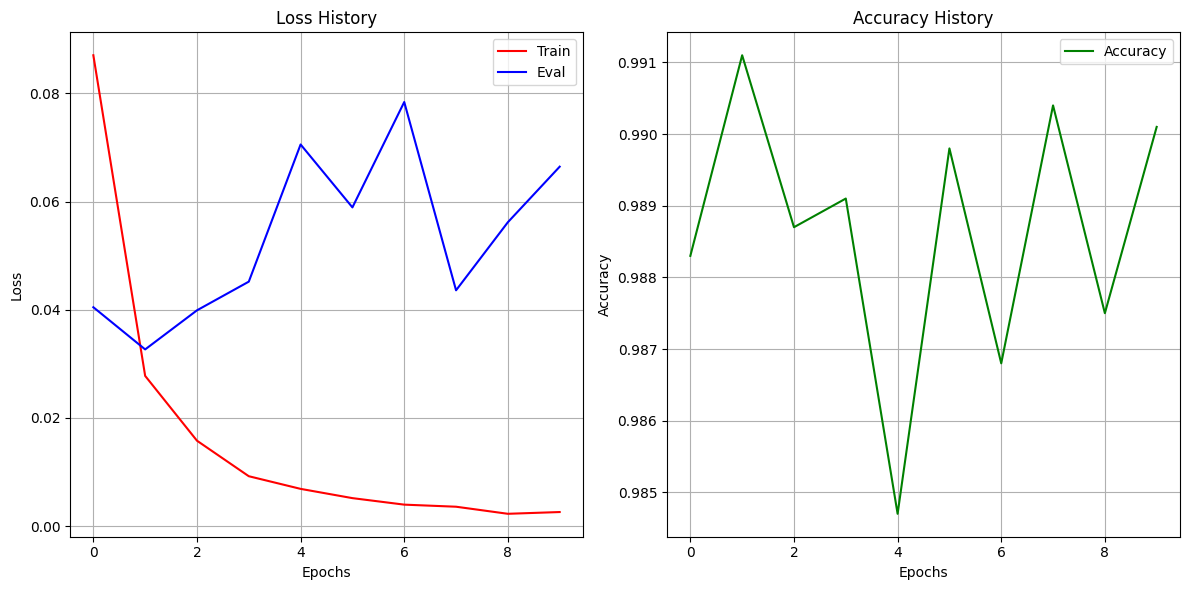

In [ ]:
show_loss_and_accuracy_history(losses_train, losses_val, accuracy)

In [ ]:
os.makedirs('../models', exist_ok=True)
torch.save(model, '../models/lstm_model.pth')

Jak widzimy, strata ewaluacji rośnie, podczas gdy dokładność również się poprawia. Można by dodać kilka dodatkowych epok treningu, ale może to prowadzić do przeuczenia modelu (overfitting).

## Model językowy z blokiem GRU

In [26]:
class LM(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind['<pad>'])
        self.GRU = nn.GRU(hidden_dim, int(hidden_dim / 2), num_layers = 3, batch_first = True, dropout = 0.1)
          
        self.linear = nn.Sequential(
            nn.Linear(int(hidden_dim / 2), hidden_dim),
            nn.Tanh(),
            nn.Dropout(p=0.3)
        )
        self.prediction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        
        output, hidden = self.GRU(embeddings)
        output = output.mean(dim = 1)
        
        return self.prediction(self.linear(output))

In [27]:
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses_train, losses_val, accuracy = train(model, criterion, optimizer, train_dataloader, val_dataloader, 10)

Train epoch 1: 100%|██████████| 2312/2312 [25:30<00:00,  1.51it/s]


Epoch 1/10 - Train Loss: 0.0901, Eval Loss: 0.0439, Accuracy: 0.9875


Train epoch 2: 100%|██████████| 2312/2312 [28:36<00:00,  1.35it/s]


Epoch 2/10 - Train Loss: 0.0319, Eval Loss: 0.0479, Accuracy: 0.9829


Train epoch 3: 100%|██████████| 2312/2312 [28:27<00:00,  1.35it/s]


Epoch 3/10 - Train Loss: 0.0197, Eval Loss: 0.0417, Accuracy: 0.9888


Train epoch 4: 100%|██████████| 2312/2312 [26:40<00:00,  1.44it/s]


Epoch 4/10 - Train Loss: 0.0144, Eval Loss: 0.0326, Accuracy: 0.9914


Train epoch 5: 100%|██████████| 2312/2312 [27:30<00:00,  1.40it/s]


Epoch 5/10 - Train Loss: 0.0097, Eval Loss: 0.0428, Accuracy: 0.9882


Train epoch 6: 100%|██████████| 2312/2312 [25:00<00:00,  1.54it/s]


Epoch 6/10 - Train Loss: 0.0074, Eval Loss: 0.0421, Accuracy: 0.9899


Train epoch 7: 100%|██████████| 2312/2312 [25:06<00:00,  1.54it/s]


Epoch 7/10 - Train Loss: 0.0065, Eval Loss: 0.0496, Accuracy: 0.9882


Train epoch 8: 100%|██████████| 2312/2312 [28:22<00:00,  1.36it/s]


Epoch 8/10 - Train Loss: 0.0052, Eval Loss: 0.0611, Accuracy: 0.9868


Train epoch 9: 100%|██████████| 2312/2312 [28:26<00:00,  1.35it/s]


Epoch 9/10 - Train Loss: 0.0053, Eval Loss: 0.0496, Accuracy: 0.9903


Train epoch 10: 100%|██████████| 2312/2312 [23:37<00:00,  1.63it/s]


Epoch 10/10 - Train Loss: 0.0047, Eval Loss: 0.0525, Accuracy: 0.9894


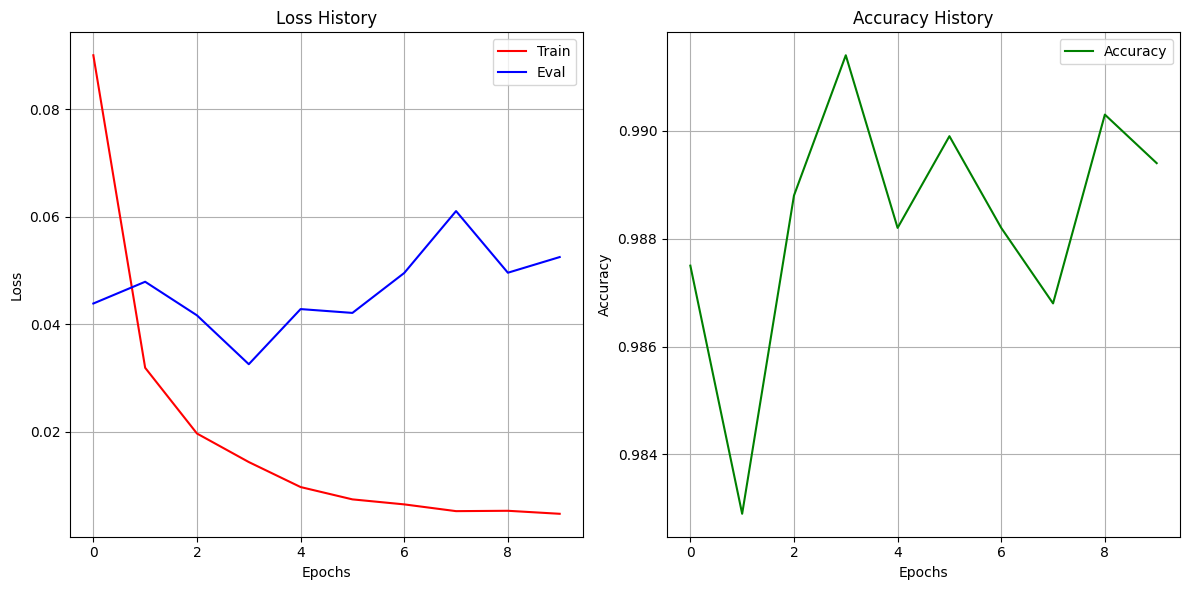

In [ ]:
show_loss_and_accuracy_history(losses_train, losses_val, accuracy)

In [ ]:
os.makedirs('../models', exist_ok=True)
torch.save(model, '../models/gru_model.pth')

## Model językowy z blokiem vanilla RNN

In [17]:
class LM(nn.Module):
    def __init__(self, hidden_dim, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim, padding_idx=word2ind['<pad>'])
        self.RNN = nn.RNN(hidden_dim, int(hidden_dim / 2), num_layers = 3, batch_first = True, dropout = 0.1, bidirectional = True)
          
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.Tanh(),
            nn.Dropout(p=0.3)
        )
        self.prediction = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2)
        )
        
    def forward(self, input_batch):
        embeddings = self.embedding(input_batch)
        
        output, hidden = self.RNN(embeddings)
        output = output.mean(dim = 1)
        
        return self.prediction(self.linear(output))

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LM(256, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [21]:
losses_train, losses_val, accuracy = train(model, criterion, optimizer, train_dataloader, val_dataloader, 3)

Train epoch 1: 100%|██████████| 2315/2315 [31:18<00:00,  1.23it/s]


Epoch 1/3 - Train Loss: 0.1243, Eval Loss: 0.0699, Accuracy: 0.9745


Train epoch 2: 100%|██████████| 2315/2315 [35:42<00:00,  1.08it/s]


Epoch 2/3 - Train Loss: 0.0450, Eval Loss: 0.0538, Accuracy: 0.9856


Train epoch 3: 100%|██████████| 2315/2315 [31:07<00:00,  1.24it/s]


Epoch 3/3 - Train Loss: 0.0559, Eval Loss: 0.0580, Accuracy: 0.9845


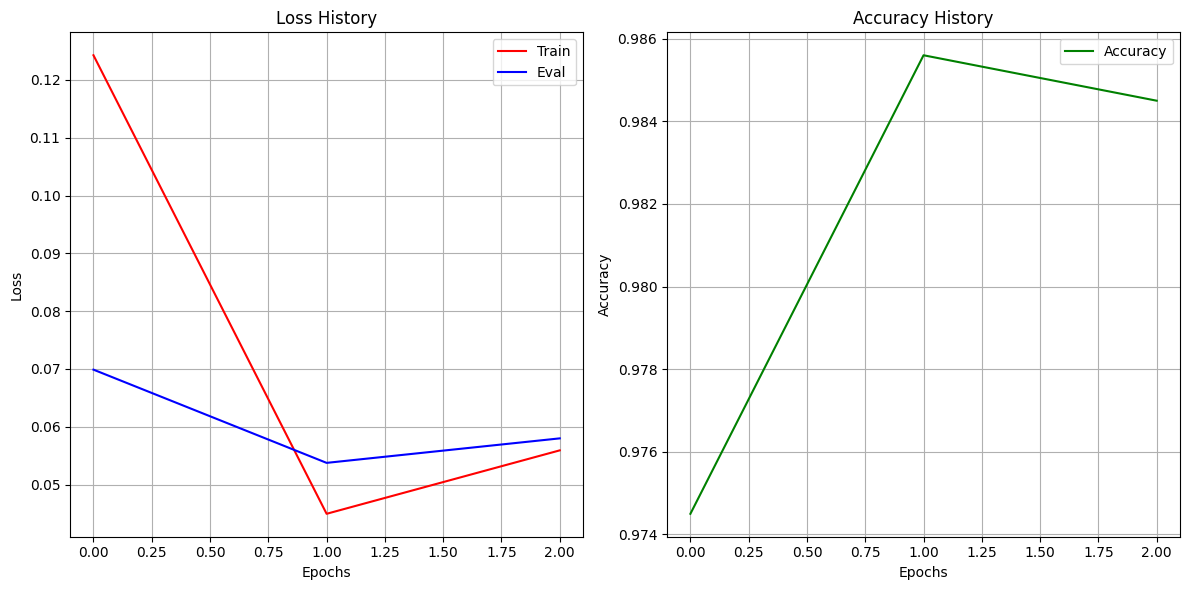

In [23]:
show_loss_and_accuracy_history(losses_train, losses_val, accuracy)

In [32]:
os.makedirs('../models', exist_ok=True)
torch.save(model, '../models/rnn_model.pth')

Co zaskakujące, vanilla RNN również sprawdził się bardzo dobrze, osiągając dokładność 0,98 na moim zbiorze walidacyjnym.

## Podsumowanie

Po zbudowaniu i przetestowaniu trzech modeli zauważyłem, że zadanie klasyfikacji spamu jest stosunkowo proste dla sieci neuronowych. Można je również łatwo zaimplementować za pomocą standardowych metod programistycznych — wystarczy zidentyfikować kilka słów kluczowych często występujących w spamie i napisać skrypt je wykrywający. Im więcej takich słów zawiera wiadomość, tym większe prawdopodobieństwo, że jest to spam. Dlatego też, już po jednej epoce treningu, moje modele osiągnęły dokładność przewidywań na poziomie 98%. Do mojej aplikacji wybrałem najlepszy model spośród wszystkich, którym okazał się GRU.